In [1]:
#!pip install pandas

# 1.  Conocimiento del dataset de trabajo

## a Ubique los datos en MovieLens 20M Dataset. Allí encuentra la información técnica y práctica para el uso de los datos, así como los requerimientos para su uso.

Este dataset es un referente en sistemas de recomendación. Proporciona una visión amplia de las preferencias de los usuarios durante dos décadas (1995-2015). 

* Volumen: ~20 millones de calificaciones y ~465,000 etiquetas (tags). 
* Alcance: ~27,000 películas evaluadas por ~138,000 usuarios. 

Descripción de las tablas: 

* df_genome_scores: Tabla que muestra la relevancia de las peliculas.  
* df_genome_tags: Tabla donde muestra información de la película, llave primaria tagId. 
* df_link: Tabla donde muestra la calificación en IMdb y TMdb, llave primaria movieId.  
* df_movie: Tabla de inventario principal. Contiene el título (con año de estreno) y los géneros categorizados, facilitando el filtrado por categorías. 
* df_rating: El corazón del dataset. Muestra la calificación realizada por un usuario a una película y el tiempo donde ocurrió el evento. 
* df_tag: Son palabras clave creadas libremente por los usuarios, aportando un lenguaje más natural y subjetivo que los géneros 

A continuacion se realiza el proceos de cargar cada una de las tablas a un dataframe en pandas

In [ ]:
#!{sys.executable} -m pip install scikit-learn
#! {sys.executable} -m pip install matplotlib
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

df_genome_scores=pd.read_csv(r"C:\Users\Diego\Documents\sistemas-recomendacion\taller1\Taller-1-Back\data\genome_scores.csv")
df_genome_tags=pd.read_csv(r"C:\Users\Diego\Documents\sistemas-recomendacion\taller1\Taller-1-Back\data\genome_tags.csv")
df_link=pd.read_csv(r"C:\Users\Diego\Documents\sistemas-recomendacion\taller1\Taller-1-Back\data\link.csv")
df_movie=pd.read_csv(r"C:\Users\Diego\Documents\sistemas-recomendacion\taller1\Taller-1-Back\data\movie.csv")
df_rating=pd.read_csv(r"C:\Users\Diego\Documents\sistemas-recomendacion\taller1\Taller-1-Back\data\rating.csv")
df_tag=pd.read_csv(r"C:\Users\Diego\Documents\sistemas-recomendacion\taller1\Taller-1-Back\data\tag.csv")


## b Estudie el formato de los datos, en particular identifique la manera de identificar qué información refleja la interacción entre usuarios e ítems.

La conexión entre los usuarios y los ítems (películas) se articula mediante la tabla ratings.csv asi: 
* Escala de Calificación: Los usuarios expresan su preferencia en una escala de 0.5 a 5.0 
* Dimensión Temporal: Cada interacción incluye un timestamp (en formato Unix), esencial para analizar la evolución de las preferencias. 
* Identificadores: La interacción se mapea mediante las llaves userId y movieId, que permiten construir la matriz de dispersión (sparse matrix) necesaria para modelos de filtrado colaborativo. 
Para realizar la caracterización de los items (películas) la tabla movies.csv contiene el catálogo de metadatos así: 
* Atributos de Contenido: contiene múltiples etiquetas de categorías. 
* Dimensión Temporal:  contiene información del año de estreno del item. 

# 2. Pre-procesamiento de datos  

## a. Transforme los datos correspondientes a la interacción entre usuarios e ítems, implementando una estrategia para convertir estos datos en unos que sean compatibles con los modelos vistos en clase. Justifique en el informe sus decisiones en este paso.  

Como el conjunto de ratings es tan grande, se decide aplicar una técnica de muestreo estratificado por género con el fin de trabajar con una muestra representativa de los datos sin perder información clave de ella. Asimismo, como una pelicula puede estar asociada a varios géneros, se extrae el género principal, es decir, el primero que aparece. De este modo se asegura que por ejemplo si el 10% del total de las peliculas corresponde a terror, la muestra tambien tenga dicho porcentaje.

## Muestreo estratificado por variable categoria

In [ ]:
# Tomamos el primer género antes del '|' como categoría principal para estratificar
df_movie['main_genre'] = df_movie['genres'].apply(lambda x: x.split('|')[0])

In [ ]:

df_merged = df_rating.merge(df_movie[['movieId', 'main_genre']], on='movieId')

# 4. Muestreo Estratificado (10%)
# Usamos 'stratify' sobre el género principal para mantener la proporción
sample_df, _ = train_test_split(
    df_merged, 
    train_size=0.10, 
    stratify=df_merged['main_genre'], 
    random_state=42, # Tu "shuffle" garantizado
    shuffle=True
)
print(f"Tamaño de la muestra: {len(sample_df)} registros.")

Tamaño de la muestra: 2000026 registros.


In [49]:
df_merged['userId'].agg('nunique')

138493

In [48]:
sample_df['userId'].agg('nunique')

135681

Cuando se analiza la cantidad de usuarios unicos tanto para la muestra (135.681) como para el dataset completo (138.493), se evidencia que la muestra tiene una representatividad muy alta de los usuarios en ella

## Distribucion calificaciones en la muestra y dataset original

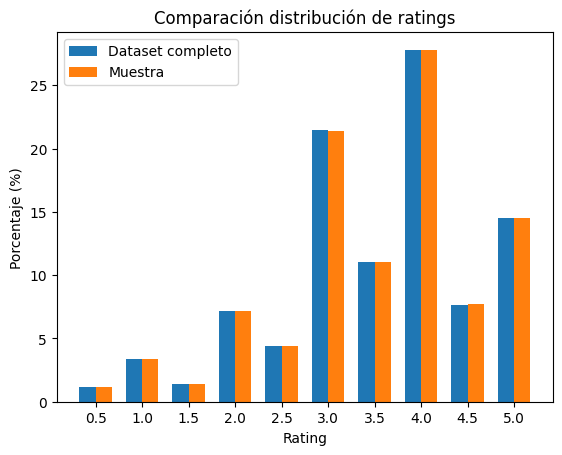

In [ ]:
# plt.show()
import numpy as np
import matplotlib.pyplot as plt

# Distribución muestra
rating_dist_sample = (
    sample_df["rating"]
    .value_counts(normalize=True, dropna=False)
    .sort_index() * 100
)

# Distribución completa
rating_dist_full = (
    df_rating["rating"]
    .value_counts(normalize=True, dropna=False)
    .sort_index() * 100
)

# Asegurar mismo orden de índices
ratings = sorted(set(rating_dist_full.index).union(set(rating_dist_sample.index)))

rating_dist_full = rating_dist_full.reindex(ratings, fill_value=0)
rating_dist_sample = rating_dist_sample.reindex(ratings, fill_value=0)

x = np.arange(len(ratings))
width = 0.35

plt.figure()
plt.bar(x - width/2, rating_dist_full.values, width, label="Dataset completo")
plt.bar(x + width/2, rating_dist_sample.values, width, label="Muestra")

plt.xticks(x, ratings)
plt.xlabel("Rating")
plt.ylabel("Porcentaje (%)")
plt.title("Comparación distribución de ratings")
plt.legend()

plt.show()

Cuando se observa la distribucion de las calificaciones en el dataset completo como en la muestra, se observa que la muestra conserva la misma distribucion

## Cantidad de usuario por cantidad de calificaciones en la muestra y dataset original

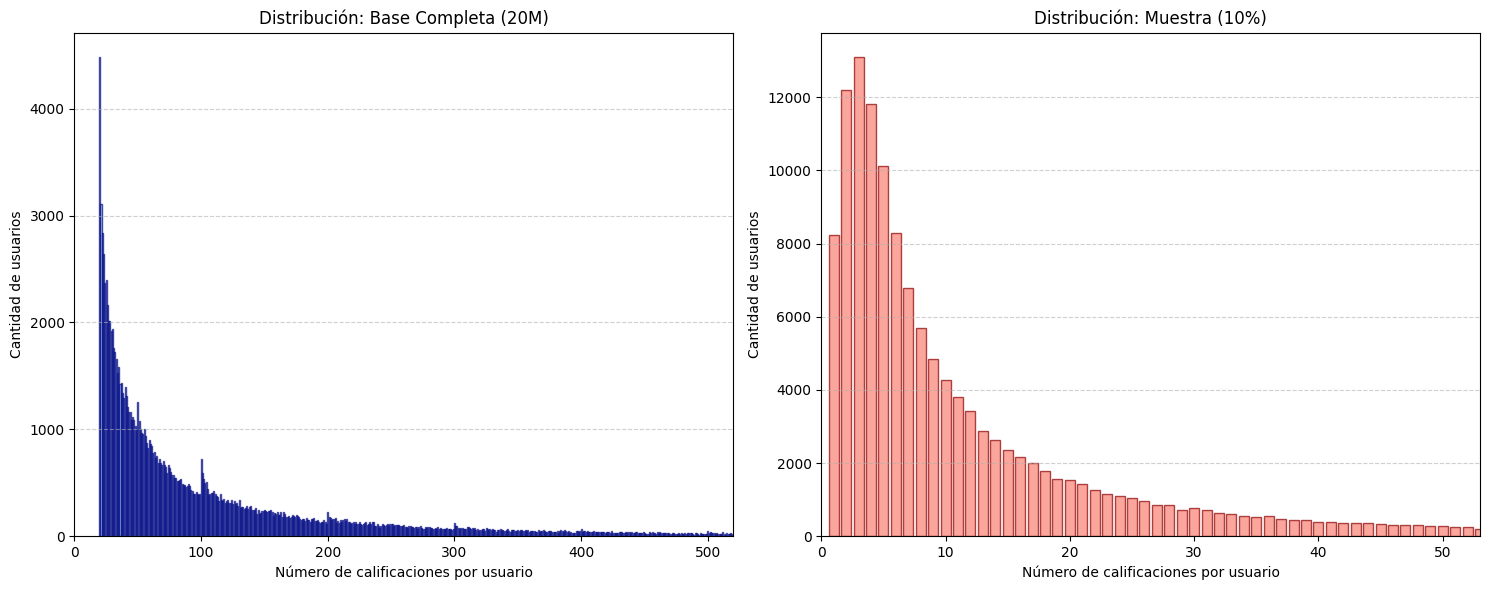

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PROCESAMIENTO ---

# Cálculo para la MUESTRA
user_activity_sample = sample_df.groupby("userId")["rating"].count()
x_max_sample = np.percentile(user_activity_sample, 95) # Usamos 95 para ver mejor el grueso
activity_filtered_sample = user_activity_sample[user_activity_sample <= x_max_sample].value_counts().sort_index()

# Cálculo para la BASE COMPLETA
user_activity_full = df_rating.groupby("userId")["rating"].count()
x_max_full = np.percentile(user_activity_full, 95)
activity_filtered_full = user_activity_full[user_activity_full <= x_max_full].value_counts().sort_index()

# --- 2. GRÁFICO UNIFICADO ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) # 1 fila, 2 columnas

# Gráfico 1: Base Completa
ax1.bar(activity_filtered_full.index, activity_filtered_full.values, color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_title("Distribución: Base Completa (20M)")
ax1.set_xlabel("Número de calificaciones")
ax1.set_ylabel("Cantidad de usuarios")
ax1.set_xlim(0, x_max_full)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Gráfico 2: Muestra
ax2.bar(activity_filtered_sample.index, activity_filtered_sample.values, color='salmon', edgecolor='darkred', alpha=0.7)
ax2.set_title("Distribución: Muestra (10%)")
ax2.set_xlabel("Número de calificaciones ")
ax2.set_ylabel("Cantidad de usuarios")
ax2.set_xlim(0, x_max_sample)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout() # Ajusta automáticamente los espacios entre gráficos
plt.show()

Cuando se analiza la cantidad de usuarios que calificaron peliculas tanto en la muestra como en la base orginal, ambas tienen el mismo comportamiento de cola larga en donde muchos usuarioscalifican poco y muy pocos usuarios califican un gran numero de peliculas

## DISTRIBUCIÓN DE CATEGORIA EN EL DATASET ORIGINAL 

In [10]:
df_movie['main_genre'] = df_movie['genres'].apply(lambda x: x.split('|')[0])

# 2. Crear un diccionario para mapear MovieID -> Género (Búsqueda ultrarrápida)
genre_map = dict(zip(df_movie['movieId'], df_movie['main_genre']))

# 3. Procesar ratings.csv en pedazos de 1 millón de filas
counts_total = pd.Series(dtype='int64')

for chunk in pd.read_csv(r"C:\Users\Diego\Documents\sistemas-recomendacion\taller1\Taller-1-Back\data\rating.csv", chunksize=1000000, usecols=['movieId']):
    # Mapeamos los géneros en el pedazo actual
    chunk_genres = chunk['movieId'].map(genre_map)
    # Contamos y sumamos al acumulador
    counts_total = counts_total.add(chunk_genres.value_counts(), fill_value=0)

# 4. Calcular porcentajes finales
distribucion_original = (counts_total / counts_total.sum() * 100).sort_values(ascending=False)

print("Distribución Real del Dataset Completo:")
print(distribucion_original)

Distribución Real del Dataset Completo:
movieId
Action                28.070671
Comedy                25.217818
Drama                 19.274542
Adventure              9.613964
Crime                  6.927479
Horror                 2.630230
Animation              2.186591
Children               2.109352
Documentary            1.033086
Mystery                1.014207
Thriller               0.762005
Fantasy                0.323741
Sci-Fi                 0.208037
Western                0.166598
Film-Noir              0.160753
Musical                0.145378
Romance                0.134173
War                    0.019420
(no genres listed)     0.001805
IMAX                   0.000150
dtype: float64


## DISTRIBUCION DE CATEGORIA EN LA MUESTRA

In [ ]:

porcentajes = (
    sample_df['main_genre']
    .value_counts(normalize=True) * 100
).sort_values(ascending=False)

print(porcentajes)

main_genre
Action                28.070685
Comedy                25.217822
Drama                 19.274549
Adventure              9.613975
Crime                  6.927460
Horror                 2.630216
Animation              2.186572
Children               2.109373
Documentary            1.033087
Mystery                1.014187
Thriller               0.761990
Fantasy                0.323746
Sci-Fi                 0.208047
Western                0.166598
Film-Noir              0.160748
Musical                0.145398
Romance                0.134198
War                    0.019400
(no genres listed)     0.001800
IMAX                   0.000150
Name: proportion, dtype: float64


Se comprueba que la muestra conserva la distribucion por categoria respecto al dataset original

## Escribiendo en un archivo csv la muestra generada a partir de la estratificación por categoria

In [ ]:
#sample_df.to_csv("muestra_ratings.csv",index=False)